In [28]:
import os, gc
import sys, pdb
import copy, time
import json, random

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path

import matplotlib
import os

import torch

from matplotlib import colors
import matplotlib.pyplot as plt
from colorama import Style, Fore
# %matplotlib inline ipnyb

from dataloader.my_loader import MyDataLoader
from dataloader.OAutoEncoder_loader import ARCDataset

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from visualization.my_vis import ARCPlottor


from models.O_Auto_Encoder import *

for dirname, _, filenames in os.walk('/home/hyunseok/enssamble/settings'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

local_path = "/home/hyunseok/enssamble/data/kaggle/"
with open("/home/hyunseok/enssamble/settings/kaggle_data_file_name.json",'r') as file:
    path_dict = json.load(file)
    data = MyDataLoader("arcprize", path_dict, local_path) 
    data.cur_data_mode("train")

plotter = ARCPlottor()

/home/hyunseok/enssamble/settings/kaggle_data_file_name.json
/home/hyunseok/enssamble/settings/kaggle_data_file_name copy.json
train_problem is loaded: /home/hyunseok/enssamble/data/kaggle/arc-agi_training_challenges.json
train_target_goal is loaded: /home/hyunseok/enssamble/data/kaggle/arc-agi_training_solutions.json
evaluation_problem is loaded: /home/hyunseok/enssamble/data/kaggle/arc-agi_evaluation_challenges.json
evaluation_target_goal is loaded: /home/hyunseok/enssamble/data/kaggle/arc-agi_evaluation_solutions.json
test_problem is loaded: /home/hyunseok/enssamble/data/kaggle/arc-agi_test_challenges.json
predicted_target_goal is loaded: /home/hyunseok/enssamble/data/kaggle/arc-agi_test_challenges.json
train data is set


In [101]:
!g++ -pthread -lpthread -O3 -std=c++17 -o ./SkleanTree ./models/SkleanTree.cpp
!./SkleanTree

inputs: 0
features: 50
columns: 50


101
Epoch : 201, Loss: 0.04516, Lowest Loss: 0.04439

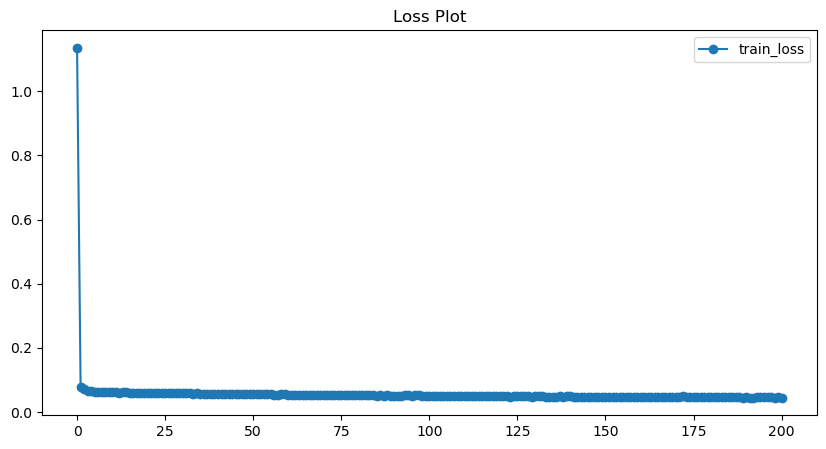

/tmp/ipykernel_1942749/1753061032.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


In [5]:
BASE_FOLDER = '/home/hyunseok/enssamble/data/kaggle/'
file_list = [
    f'{BASE_FOLDER}/arc-agi_training_challenges.json',
    f'{BASE_FOLDER}/arc-agi_evaluation_challenges.json',
    f'{BASE_FOLDER}/arc-agi_test_challenges.json'

]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_dataset = ARCDataset(file_list)
train_dataset.set_dataset()
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

Dimension = train_dataset.dim
Keys = train_dataset.keys

IN_DIM = 100 + 1
print(IN_DIM)
OUT_DIM = 100
LATENT_DIM = 1024
model = LSTM(IN_DIM, OUT_DIM, LATENT_DIM).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
training = Training(model, train_loader, criterion, optimizer, device)
training.train()

model.load_state_dict(torch.load('model.pth'))
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])

norm = colors.Normalize(vmin=0, vmax=10)
sanity = Prediction(model, train_dataset, Dimension, cmap, norm, device)



In [ ]:
def plot_pic(x):
    plt.imshow(np.array(x), cmap=cmap, norm=norm)
    plt.show()
for i in range(100):
    result = sanity.predict(model,[sanity.data.data[i][1],sanity.data.data[i][2]])
    print(result)
    output1 = sanity.remove_tail_zeros(sanity.data.data[i][0], torch.round(result * 9), 'out')
    plot_pic(output1)

In [24]:
test_dataset = ARCDataset(f'{BASE_FOLDER}/arc-agi_test_challenges.json', 'test', dim=Dimension, keys=Keys)
test_dataset.set_dataset()
pred = Prediction(model, test_dataset, Dimension, cmap, norm, device)

In [ ]:
test_dataset = ARCDataset(f'{BASE_FOLDER}/arc-agi-.json', 'test', dim=Dimension, keys=Keys)
test_dataset.set_dataset()
pred = Prediction(model, test_dataset, Dimension, cmap, norm, device)

In [ ]:
for i in range(len(pred.data)):
    result = pred.predict(model,[pred.data.data[i][1],pred.data.data[i][2]])
    output1 = pred.remove_tail_zeros(pred.data.data[i][0], torch.round(result * 9), 'out')
    plot_pic(output1)

In [14]:
from models.color_counter import *
from models.color_counter_dsl import *
from models.different_solvers import *

<function models.different_solvers.check_repeating(task, has_complete=False)>

In [15]:
# ..................................................................................... 1
def ganswer_answer(ganswer):

    answer = []
    for j in range(len(ganswer)):
        ganswer_j = ganswer[j].tolist()

        if (ganswer_j not in answer):
            answer.append(ganswer_j)

    return answer

# ..................................................................................... 2
def ganswer_answer_1(ganswer):

    answer = []
    for j in range(len(ganswer)):
        ganswer_j = ganswer[j]

        if (ganswer_j not in answer):
            answer.append(ganswer_j)

    return answer

# ..................................................................................... 3
def prn_plus(prn, answer):

    for j in range(len(answer)):
        prn = prn + [answer[j]]

        if (j == 0):
            prn = prn + [answer[j]]

    return prn

# ..................................................................................... 4
def prn_select_2(prn):
    if (len(prn) > 2):

        value_list = []
        string_list = []
        for el in prn:
            value = 0
            for i in range(len(prn)):
                if el == prn[i]:
                    value +=1
            value_list.append(value)
            string_list.append(str(el))

        prn_df  = pd.DataFrame({'prn': prn , 'value': value_list, 'string': string_list})
        prn_df1 = prn_df.drop_duplicates(subset=['string'])
        prn_df2 = prn_df1.sort_values(by='value', ascending=False)

        prn = prn_df2['prn'].values.tolist()[:2]

    return prn

# ..................................................................................... 5
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])

norm = colors.Normalize(vmin=0, vmax=9)
color_list = ["black", "blue", "red", "green", "yellow", "gray", "magenta", "orange", "sky", "brown"]

def plot_pic(x):
    plt.imshow(np.array(x), cmap=cmap, norm=norm)
    plt.show()

In [ ]:
task_id = pred.data.data[0][0]
task = data.cur_problem[task_id]

In [35]:
test_input = np.array(task['test'][0]['input'])
test_input

array([[7, 0, 7],
       [7, 0, 7],
       [7, 7, 0]])

In [40]:
 # ............................................................................... 1 - Different Solvers
if check_repeating(task, True):
    ganswer = predict_repeating(test_input)

    if (ganswer!= []):
        answer = ganswer_answer(ganswer)
        prn = prn_plus(prn, answer)

# ________________________________________________________
if check_grid(task) and check_sub_grid_2x(task):
    ganswer = predict_transforms_grid_2x(task, test_input)

    if (ganswer!= []):
        answer = ganswer_answer(ganswer)
        prn = prn_plus(prn, answer)

# ________________________________________________________
if check_grid(task) and check_chess(task, False, True):
    ganswer = predict_chess(grid_filter(test_input))

    if (ganswer!= []):
        answer = ganswer_answer(ganswer)
        prn = prn_plus(prn, answer)

# ________________________________________________________
if check_tiles_shape(task, True):
    ganswer = predict_tiles_shape(task, test_input)

    if (ganswer!= []):
        answer = ganswer_answer(ganswer)
        prn = prn_plus(prn, answer)

# ________________________________________________________
if check_grid(task) and check_grid_transforms(task):
    ganswer = predict_grid_transforms(task, test_input)

    if (ganswer!= []):
        answer = ganswer_answer(ganswer)
        prn = prn_plus(prn, answer)

# ________________________________________________________
if check_sub_mask(task):
    ganswer = predict_repeating_mask(test_input)

    if (ganswer!= []):
        answer = ganswer_answer(ganswer)
        prn = prn_plus(prn, answer)

# ............................................................................... 2 - Sklearn tree
if check_subitem(task):
    train_t = format_features(task)
    test_t = make_features(test_input)
    ganswer = tree1(train_t, test_t, test_input)

    if (ganswer!= []):
        answer = ganswer_answer(ganswer)
        prn = prn_plus(prn, answer)

# # ............................................................................... 3 - Symmetry Repairing
# basic_task = Create(task, i)
basic_task = Create(task, 0)

ganswer = symmetry_repairing(basic_task)

if (ganswer != -1):
    answer = ganswer_answer_1(ganswer)
    prn = prn_plus(prn, answer)

# # ............................................................................... 4 - Colors Counter
basic_task = Create(task, 0)
answer = colors_counter(basic_task)

if (answer != -1):
    answer = [answer]
    prn = prn_plus(prn, answer)
